<a href="https://colab.research.google.com/github/kritika-z/major-project/blob/main/eeg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files
import pandas as pd
import io

# Upload files manually
uploaded = files.upload()  # Opens a file dialog

# Check uploaded filenames
print("Uploaded files:", uploaded.keys())

# Load epilepsy and Alzheimer datasets using their actual filenames
epi = pd.read_csv(io.BytesIO(uploaded[list(uploaded.keys())[0]]))
alz = pd.read_csv(io.BytesIO(uploaded[list(uploaded.keys())[1]]))

# Add labels
epi['Diagnosis'] = 'Epilepsy'
alz['Diagnosis'] = 'Alzheimer'

# Combine into one dataframe
data = pd.concat([epi, alz], ignore_index=True)

print(data.head())
print(data['Diagnosis'].unique())

Saving epilepsy - epilepsy.csv to epilepsy - epilepsy.csv
Saving Multi_Patient_Alzheimers_EEG.csv to Multi_Patient_Alzheimers_EEG.csv
Uploaded files: dict_keys(['epilepsy - epilepsy.csv', 'Multi_Patient_Alzheimers_EEG.csv'])
  Patient_ID  Time  TP9_signal  AF7_signal  AF8_signal  TP10_signal Diagnosis
0          0   0.0         0.0      1280.0      1536.0       5632.0  Epilepsy
1          0   1.0         1.0      1281.0      1537.0       5633.0  Epilepsy
2          0   2.0         2.0      1282.0      1538.0       5634.0  Epilepsy
3          0   3.0         3.0      1283.0      1539.0       5635.0  Epilepsy
4          0   4.0         4.0      1284.0      1540.0       5636.0  Epilepsy
['Epilepsy' 'Alzheimer']


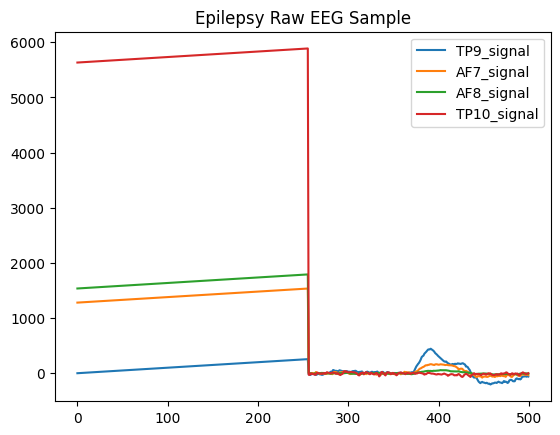

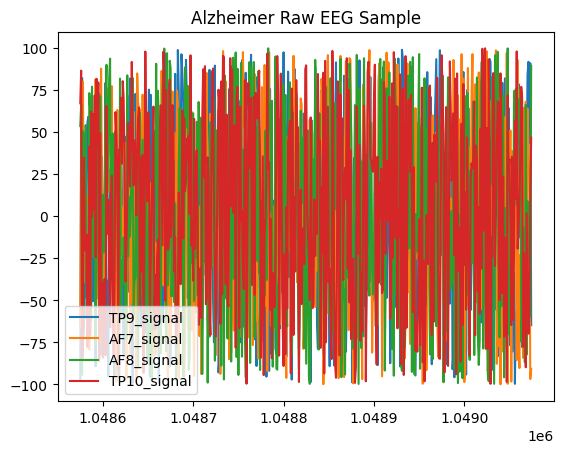

In [ ]:
# Visualize raw EEG signals from each class
for diag in data['Diagnosis'].unique():
    sample = data[data['Diagnosis']==diag][channels].iloc[:500]  # first 500 timesteps
    sample.plot(title=f"{diag} Raw EEG Sample")
    plt.show()

In [ ]:
# Step 0: Import libraries
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, lfilter, resample, iirnotch
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout, Flatten
from tensorflow.keras.utils import to_categorical

In [ ]:
from mne.preprocessing import ICA
import mne

In [ ]:
def butter_bandpass(lowcut, highcut, fs, order=4):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

In [ ]:
def bandpass_filter(data, lowcut=0.5, highcut=45, fs=256):
    b, a = butter_bandpass(lowcut, highcut, fs)
    return lfilter(b, a, data)

In [ ]:
def notch_filter(data, fs, freq=50.0, Q=30):
    b, a = iirnotch(freq/(fs/2), Q)
    return lfilter(b, a, data)

In [ ]:
# raw_data shape: (n_channels, n_samples)
raw_data = np.random.randn(8, 983040)  # Example: 8 channels, 120 seconds at 8192 Hz

In [ ]:
# Downsample to 256 Hz
target_fs = 256
num_samples = int(raw_data.shape[1] * target_fs / 8192)
data_downsampled = resample(raw_data, num_samples, axis=1)
fs = target_fs
print(f"Downsampled shape: {data_downsampled.shape}")

Downsampled shape: (8, 30720)


In [ ]:
# Filtering
data_filtered = np.array([bandpass_filter(ch, fs=fs) for ch in data_downsampled])
data_filtered = np.array([notch_filter(ch, fs=fs) for ch in data_filtered])

In [ ]:
# Normalization
scaler = StandardScaler()
data_normalized = scaler.fit_transform(data_filtered.T).T

In [29]:
    # Save preprocessed data
    np.savez("preprocessed_eeg.npz", data_normalized=data_normalized, fs=fs)
    print("Preprocessed data saved to preprocessed_eeg.npz")

Preprocessed data saved to preprocessed_eeg.npz


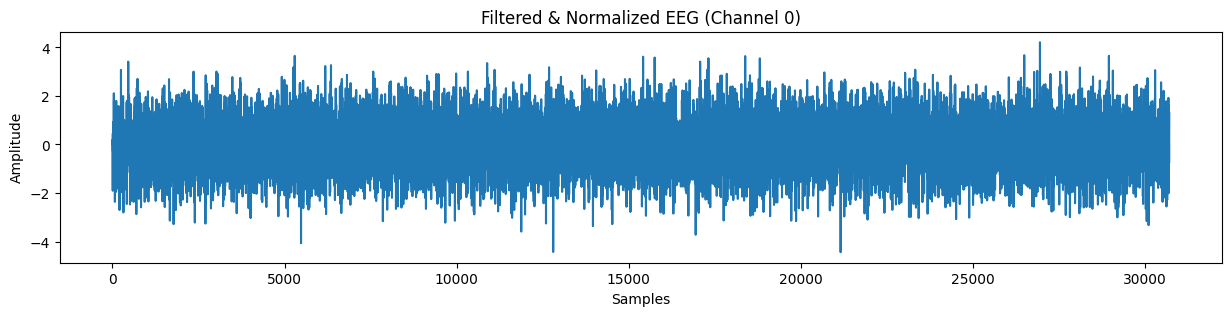

In [ ]:
# Optional: Plot a sample channel
plt.figure(figsize=(15,3))
plt.plot(data_normalized[0])
plt.title("Filtered & Normalized EEG (Channel 0)")
plt.xlabel("Samples")
plt.ylabel("Amplitude")
plt.show()

In [ ]:
# Segmentation
# -----------------------------

def segment_signal(data, window_size_sec=5, step_size_sec=2.5, fs=256):
    window_size = int(window_size_sec * fs)
    step_size = int(step_size_sec * fs)
    segments = []
    for start in range(0, data.shape[1] - window_size + 1, step_size):
        segments.append(data[:, start:start+window_size])
    return np.array(segments)

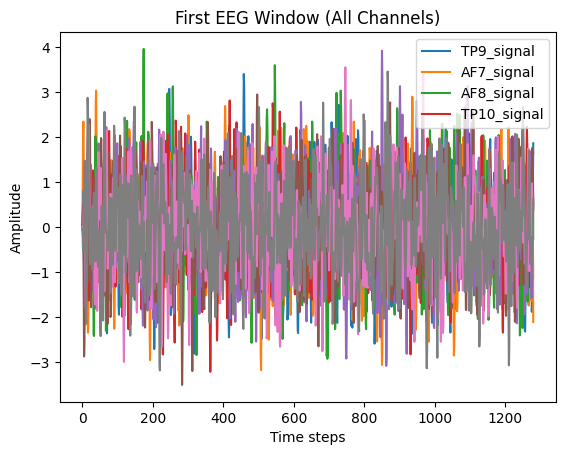

In [ ]:
plt.plot(X[0])  # first segment
plt.title("First EEG Window (All Channels)")
plt.xlabel("Time steps")
plt.ylabel("Amplitude")
plt.legend(channels)
plt.show()

In [ ]:
segments = segment_signal(data_normalized, window_size_sec=5, step_size_sec=2.5, fs=fs)
print(f"Segmented data shape: {segments.shape}")  # (n_segments, n_channels, window_samples)

Segmented data shape: (47, 8, 1280)


In [ ]:
#Data Augmentation
# -----------------------------

def augment_data(segments):
    augmented = []
    for seg in segments:
        # Gaussian noise
        noise = np.random.normal(0, 0.01, seg.shape)
        augmented.append(seg + noise)
        # Scaling
        scale = np.random.uniform(0.9, 1.1)
        augmented.append(seg * scale)
        # Time shift (roll)
        shift = np.random.randint(-5, 5)
        augmented.append(np.roll(seg, shift, axis=1))
    return np.array(augmented)

augmented_segments = augment_data(segments)
print(f"Augmented data shape: {augmented_segments.shape}")


Augmented data shape: (141, 8, 1280)


In [ ]:
# Assuming binary labels for simplicity
labels = np.random.randint(0, 2, segments.shape[0])
labels_augmented = np.tile(labels, 3)  # Because augment_data triples the dataset

In [ ]:
# Transpose to (samples, timesteps, channels)
X = augmented_segments.transpose(0,2,1)
y = to_categorical(labels_augmented, 2)

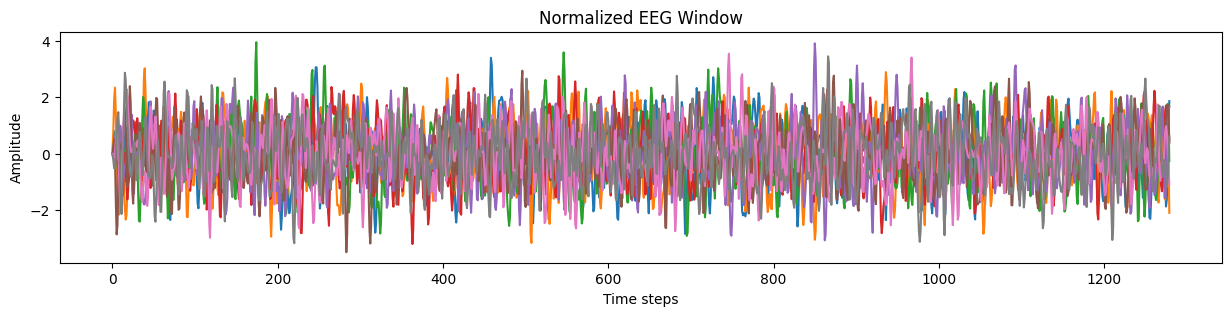

Mean per channel: [ 0.00038728 -0.00066505  0.00012409 -0.00028147  0.00041791  0.00025877
  0.00017078  0.00022496]
Std per channel: [1.00173037 1.00093499 1.00059781 1.00066111 1.0008122  1.0013551
 1.00209959 1.00102778]


In [ ]:
# --- Added Visualization and Mean/Std Check ---
plt.figure(figsize=(15,3))
plt.plot(X[0])
plt.title("Normalized EEG Window")
plt.xlabel("Time steps")
plt.ylabel("Amplitude")
plt.show()

print("Mean per channel:", X.mean(axis=(0,1)))
print("Std per channel:", X.std(axis=(0,1)))

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

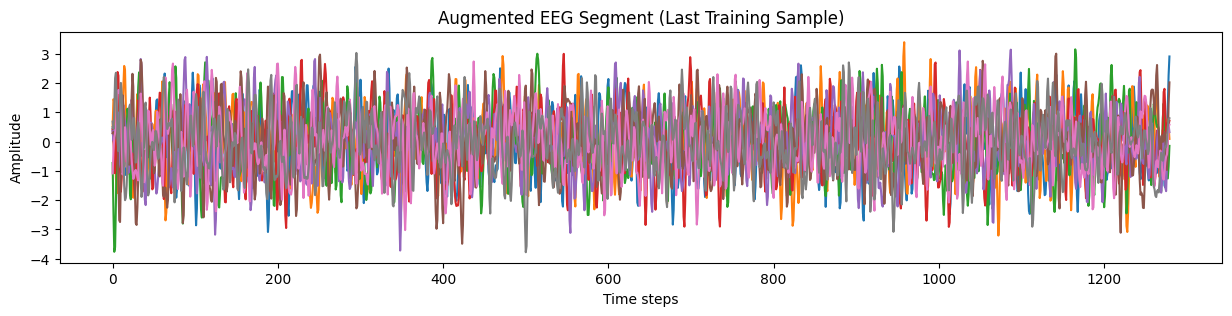

In [ ]:
# --- Plot the last augmented training sample ---
plt.figure(figsize=(15,3))
plt.plot(X_train[-1])
plt.title("Augmented EEG Segment (Last Training Sample)")
plt.xlabel("Time steps")
plt.ylabel("Amplitude")
plt.show()